# <a id='top'>Covid-19 Data Analysis</a>

The purpose of this project is to clean, explore, and draw insights from the [Johns Hopkins COVID-19 dataset](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker) and the [State and Policy Orders dataset](https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders) from data.gov. New case and death data is visualized at the state and county level and correlated with policy implementations. Finally, a regression model is being developed to estimate the expected number of new cases and deaths given the policy implementations since the start of the pandemic. At the moment, the most hopeful candidate model is Decision Tree regression with $R^2 \approx 0.25$. 

### Table of Contents

* 1 [data cleaning](#1)<br>
    * 1.1 [Johns Hopkins](#1.1)<br>
    * 1.2 [State and Policy Orders](#1.2)<br> 
* 2 [data visualization](#2)<br>
    * 2.1 [New Cases and Deaths](#2.1)<br>
    * 2.2 [Policy Data Overlay](#2.2)<br>
* 3 [correlation between cases and policies](#corr)<br>
    * 3.1 [Finding Correlations](#3.1)<br>
    * 3.2 [Evaluating Correlations](#3.2)<br>
* 4 [Predicting new cases given historical policy implementations](#4)<br>
    * 4.1 [Data preprocessing](#4.1)<br>
    * 4.2 [Test a Model](#4.2)<br>
    * 4.3 [Train / Test split](#4.3)<br> 
    * 4.4 [Systematic model training](#4.4)<br>
    * 4.5 [Model selection](#4.5)<br>
* 5 [Conclusions and Future Work](#5)<br>
 

### Associated links: 
- extended discussion of [data cleaning](https://nbviewer.jupyter.org/github/apalermo01/covid-19-data-analysis/blob/main/Covid-19%20data%20cleaning.ipynb)

- [github repo](https://github.com/apalermo01/covid-19-data-analysis)

- [Related paper](https://www.nature.com/articles/s41562-020-01009-0?fbclid=IwAR2fnHNxYtB54oHuyQmz8rEpuypgwvbWvSnY8fOQg7Zt_bLA13HsZZvecrY) on raking interventions at the international scale


# 0 Imports and configurations

In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
#di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [18]:
# configuration settings
%reset -f
%config InlineBackend.figure_format = 'svg'

# basics 
from datetime import datetime, timedelta
import time
import math
import random
import os
import json
import warnings
import re

# data analysis libraries
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# miscellaneous
from tabulate import tabulate
from IPython.display import clear_output
import us
import requests
from textwrap import dedent

# use constant font sizes for consistent plotting
BIG_FONT = 18
MED_FONT = 12
SMALL_FONT = 9

# set directories
DATASETS_DIR = "local_datasets/"
SCRIPTS_DIR = "scripts/"
RESULTS_DIR = "results/"

# 1 <a id='1'>Data Cleaning</a>
[back to top](#top)

First, load each of the datasets. df = Johns Hopkins COVID-19 dataset, df2 = policy dataset. df is queried directly from dataworld, while the policy dataset is scraped from data.gov

Load case and death data

In [19]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')

Use the HTML source to get the file name (changes with each update of the dataset). 

In [20]:
html = requests.get("https://catalog.data.gov/dataset/covid-19-state-and-county-policy-orders").text
policy_file = html.split("a href=\"/dataset/covid-19-state-and-county-policy-orders")[1]\
    .split("<span>plotly</span>")[0]\
    .split("https://plot.ly/external/?url=")[1]\
    .split("\">")[0]
df2 = pd.read_csv(policy_file)

In [21]:
print("Johns Hopkins datset (raw): ")
df.head()

Johns Hopkins datset (raw): 


,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [22]:
print("State and Policy orders dataset (raw): ")
df2.head()

State and Policy orders dataset (raw): 


,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,MS,Hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,NaN
1,AZ,NaN,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,NaN
2,OR,NaN,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,NaN
3,ND,Pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...,5.0
4,OR,Lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...,NaN


## 1.1 <a id='1.1'>Johns Hopkins Covid-19 dataset</a>
[back to top](#top)

Shorten column names then look for nulls, unexpected data types, and invalid records. A more detailed look at the data cleaning process is found in the data cleaning notebook.  

In [23]:
df.rename(columns={
    'cumulative_cases_per_100_000'  : 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000' : 'cumulative_deaths_1e6',
    'new_cases_per_100_000'         : 'new_cases_1e6', 
    'new_deaths_per_100_000'        : 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg'   : 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg'  : 'new_deaths_7day'
    }, inplace=True)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float

Check the distribution of numerical fields, number of nulls in each column, and the datatypes present in each column. 

Define a custom function to evaluate nulls and data types. This is primarily for convenience, as df.info() gives similar information but we're interested in the number of nulls and unique datatypes for each series (since by default df.info() writes 'object' when a series has heterogenous datatypes). 

In [24]:
def eval_df(df):
    """Count the number of nulls and list datatypes present in each column in the input DataFrame."""
    
    table = []
    for col in df.columns: 
        table.append([col, df[col].isnull().sum(), set([type(i) for i in df[col].values])])
        
    print(tabulate(table, headers=["field", "num_nulls", "datatypes"]))

In [25]:
df.describe()

,uid,fips_code,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
count,1.317720e+06,1.313770e+06,1.271900e+06,1.317720e+06,1.271900e+06,1.317720e+06,1.271900e+06,1.314384e+06,1.314384e+06,1.268680e+06,1.268680e+06,1.296684e+06,1.300055e+06
mean,8.352961e+07,3.310136e+04,1.013323e+05,2.255460e+03,2.213767e+03,5.196373e+01,4.305361e+01,2.129947e+01,3.770945e-01,2.186347e+01,4.169503e-01,2.165878e+01,3.956096e-01
std,3.206731e+06,1.861217e+04,3.260459e+05,1.290290e+04,3.128403e+03,3.021797e+02,7.092253e+01,1.435101e+02,5.453587e+00,5.727710e+01,2.680604e+00,1.312489e+02,2.687245e+00
min,6.307200e+07,1.001000e+03,7.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.590000e+03,-3.962000e+03,-5.975850e+03,-1.685400e+02,0.000000e+00,0.000000e+00
25%,8.401811e+07,1.908500e+04,1.121425e+04,3.000000e+00,3.143000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.402921e+07,3.101800e+04,2.595050e+04,1.420000e+02,6.413700e+02,2.000000e+00,8.710000e+00,1.000000e+00,0.000000e+00,3.810000e+00,0.000000e+00,2.000000e+00,0.000000e+00
75%,8.404612e+07,4.713300e+04,6.655225e+04,1.015000e+03,3.347062e+03,2.000000e+01,5.869250e+01,9.000000e+00,0.000000e+00,2.538000e+01,0.000000e+00,1.071000e+01,1.400000e-01
max,8.410000e+07,9.999900e+04,1.009805e+07,1.176843e+06,3.470693e+04,1.967000e+04,8.400200e+02,2.942300e+04,1.553000e+03,9.370100e+03,2.793300e+02,1.607743e+04,2.445700e+02


In [26]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  --------------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                     3950  {<class 'numpy.float64'>}
location_name                  790  {<class 'str'>, <class 'float'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population             45820  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6         45820  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6        45820  {<class 'numpy.float64'>}
new_cases                     3336  {<class 'numpy.float64'>}
new_deaths                    3336  {<class 'numpy.float64'>}
new_cases_1e6                49040  {<class 'numpy.float64'>}
new_deaths_1e6               49040  {<class 'n

While inspecting these tables a few issues become apparent: 

1) null values in most columns

2) some fields that should be integers are floats (total_population, new_cases, new_deaths)

3) some values for location_name are floats

4) negative values in new_cases, new_deaths, and their normalized equivalents 

We can likely eliminate some of these issues by throwing out some locations that are not a 'county' and locations not in the 50 states. 

In [27]:
df['location_type'].unique()

array(['county', 'special_exception', 'out_of_state',
       'count_unassigned_to_location'], dtype=object)

In [28]:
df = df.drop(df[df['location_type']!='county'].index) # drop location_types that are not counties

states = [elem.name for elem in us.states.STATES]     # get list of u.s. states
df = df.drop(df[~df['state'].isin(states)].index)     # drop anything not in one of the 50 states (also drops DC)
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
31600,84001001,county,1001.0,Autauga,Alabama,2020-01-22,55200.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
31601,84001001,county,1001.0,Autauga,Alabama,2020-01-23,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
31602,84001001,county,1001.0,Autauga,Alabama,2020-01-24,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
31603,84001001,county,1001.0,Autauga,Alabama,2020-01-25,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
31604,84001001,county,1001.0,Autauga,Alabama,2020-01-26,55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [29]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  -------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.float64'>}
location_name                    0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'str'>}
total_population                 0  {<class 'numpy.float64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                     3141  {<class 'numpy.float64'>}
new_deaths                    3141  {<class 'numpy.float64'>}
new_cases_1e6                 3141  {<class 'numpy.float64'>}
new_deaths_1e6                3141  {<class 'numpy.float64'>}
new_case

Restricting locations had the effect of throwing out nulls in fips_code, location_name, total_poplulation, cumulative_cases_1e6, and cumulative_deaths_1e6. 

Make the locations more consistent by converting 'location_name' to 'county' (this will ensure consistency with the policy dataset). Additionally, make a new column with the combined county and state name. 

In [30]:
df['full_loc_name'] = df['location_name'] + ', ' + df['state']
df['location_name'] = df['location_name'].str.lower()

# re-order columns
cols = df.columns.tolist()
cols = cols[:6] + [cols[-1]] + cols[6:-1]
df = df[cols]

df.rename(columns={'location_name' : 'county'}, inplace=True)
df.head()

,uid,location_type,fips_code,county,state,date,full_loc_name,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
31600,84001001,county,1001.0,autauga,Alabama,2020-01-22,"Autauga, Alabama",55200.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
31601,84001001,county,1001.0,autauga,Alabama,2020-01-23,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
31602,84001001,county,1001.0,autauga,Alabama,2020-01-24,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
31603,84001001,county,1001.0,autauga,Alabama,2020-01-25,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
31604,84001001,county,1001.0,autauga,Alabama,2020-01-26,"Autauga, Alabama",55200.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Next, convert 'date' to datetime. 

In [31]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

Handle the negative and null values is the numerical columns. 

The nulls in new_cases(\_1e6) and new_deaths(\_1e6) all occur on 2020-01-22, the first day on which reporting occurs, so set these to zero.  

The negative values in these columns can also be set to zero. On the [disucssion page](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) for this dataset in dataworld  user nickyforester adressed the negative values in new_cases and new_deaths with the following comment: 

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.

For those interested, there is an in-depth analysis on how these negative values are distributed in the data_cleaning notebook. 

Finally, cast all these columns to integers. 

In [32]:
cols = ['new_cases', 'new_deaths', 'new_cases_1e6', 'new_deaths_1e6']

for col in cols: 
    df[col].fillna(value=0, inplace=True)
    df[col].clip(lower=0, inplace=True)

cols2 = ["fips_code", "total_population", "new_cases", "new_deaths"]
df[cols2] = df[cols2].astype(np.int64)
df.head()

,uid,location_type,fips_code,county,state,date,full_loc_name,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day
31600,84001001,county,1001,autauga,Alabama,2020-01-22,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
31601,84001001,county,1001,autauga,Alabama,2020-01-23,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
31602,84001001,county,1001,autauga,Alabama,2020-01-24,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
31603,84001001,county,1001,autauga,Alabama,2020-01-25,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN
31604,84001001,county,1001,autauga,Alabama,2020-01-26,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,NaN,NaN


In the 7 day running averages, most of the nulls occur in the first few days, so set those to zero. 

There are additional nulls distributed throughout the dataset. Loop through these nulls and re-calculate the 7-day running average.

In [33]:
# Start timer. 
start = time.time()

# Set rolling averages to zero in the first few days of measurements.
df[['new_cases_7day', 'new_deaths_7day']] = df[['new_cases_7day', 'new_deaths_7day']].mask(
    (df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')), df[['new_cases_7day', 'new_deaths_7day']].fillna(0)
    )

# Get dataframes where normalized new_cases and new_deaths are null
nulls_case7day = df[df['new_cases_7day' ].isnull()]
nulls_death7day = df[df['new_deaths_7day'].isnull()]

# Pre-define timedelta for efficiency. 
days_7 = timedelta(days=7)

# Prepare some outputs since this function will take a while. 
i = 0
num_elem = len(nulls_case7day)
msg = "Looping through nulls in new_cases_7day. Please be patient, this may take a while"
print(msg)

# Loop through nulls in new_cases_7day
for index, data in nulls_case7day.iterrows():
    
    # Output for inpatient people like me. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
        
    if i%250 == 0: 
        clear_output()
        print(msg)
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at the datapoint of interest
    df.loc[index, ['new_cases_7day']] = np.sum((
        [df['new_cases'][(df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7
    
# Reset output. 
clear_output()
print("Looping through nulls in new_deaths_7day. Please be patient, this may take a while")
i = 0
num_elem = len(nulls_death7day)

# Loop through nulls in new_deaths_7day
for index, data in nulls_death7day.iterrows():
    
    # Output status. 
    i += 1
    if i%10 == 0: 
        print(f"index: {i}/{num_elem}")
    
    # Calculate rolling average at datapoint of interest. 
    df.loc[index, ['new_deaths_7day']] = np.sum(([df['new_deaths'][
        (df['full_loc_name'] == data.full_loc_name) & 
        ((df['date'] <= data.date) & (df['date'] > data.date-days_7))].values])) / 7

# Output complete. 
clear_output()
print("done :)")
end = time.time()
print(f"time elapsed: {end-start}")

done :)
time elapsed: 132.868319272995


Finally, make a few new columns with full location name (county, state) and normalized 7 day rolling averages. Convert location name to lowercase.

In [34]:
df["new_cases_7day_1e6" ] = df['new_cases_7day' ] / (df['total_population'] / 1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] / (df['total_population'] / 1e5)

Final check for any missed issues. 

In [35]:
eval_df(df)

field                    num_nulls  datatypes
---------------------  -----------  ----------------------------
uid                              0  {<class 'numpy.int64'>}
location_type                    0  {<class 'str'>}
fips_code                        0  {<class 'numpy.int64'>}
county                           0  {<class 'str'>}
state                            0  {<class 'str'>}
date                             0  {<class 'numpy.datetime64'>}
full_loc_name                    0  {<class 'str'>}
total_population                 0  {<class 'numpy.int64'>}
cumulative_cases                 0  {<class 'numpy.int64'>}
cumulative_cases_1e6             0  {<class 'numpy.float64'>}
cumulative_deaths                0  {<class 'numpy.int64'>}
cumulative_deaths_1e6            0  {<class 'numpy.float64'>}
new_cases                        0  {<class 'numpy.int64'>}
new_deaths                       0  {<class 'numpy.int64'>}
new_cases_1e6                    0  {<class 'numpy.float64'>}
new_deaths

## 1.2 <a id='1.2'>State and Policy Orders</a>
[back to top](#top)

Summary of expected datatypes and values: 

| column | details | accepted values |
|-----|------|--------|
| state_id | state name | string
| county | county name (this should be the same as county in the Johns Hopkins dataset) | string, county name for county level policies "statewide" for state policies
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| policy_level | scope of policy | string, 'county' or 'state
| date | date of policy implementation | datetime object
| policy_type | brief description of policy classification | datetime object
| start_stop | whether this is the start of a restriction or lifting of a restriction | 'start' or 'stop' (string)
| comments | additional information | string
| source | source for policy info | string
| total_phases | total number of phases | positive integer

Since this is mostly text-based data, skip .describe()

In [36]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  --------------------------------
state_id                0  {<class 'str'>}
county               1676  {<class 'str'>, <class 'float'>}
fips_code            1676  {<class 'numpy.float64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'str'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}
total_phases         2937  {<class 'numpy.float64'>}


Data cleaning for the policy dataset is somewhat more straightforward. To start: 

1) drop policies not implemented in the 50 states

2) convert state abbreviations to the full name 

3) re-name 'state_id' to 'state'

4) drop total_phases since we won't be using it 

5) nulls in 'county' are statewide policies, so fill nulls with 'statewide'

6) convert 'county' to lowercase

7) convert 'date' from int to datetime

In [37]:
print("Before initial cleaning: ")
df2.head()

Before initial cleaning: 


,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,MS,Hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,NaN
1,AZ,NaN,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,NaN
2,OR,NaN,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,NaN
3,ND,Pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...,5.0
4,OR,Lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...,NaN


In [38]:
abbr = [elem.abbr for elem in us.states.STATES]

df2 = df2.drop(df2[~df2['state_id'].isin(abbr)].index)                     
df2.replace(to_replace=us.states.mapping('abbr', 'name'), inplace=True)    
df2.rename(columns={'state_id' : 'state'}, inplace=True)                   
df2.drop('total_phases', axis=1, inplace=True)                             
df2['county'].fillna(value='statewide', inplace=True)                      
df2['county'] = df2['county'].str.lower()                                  
df2.loc[:, 'date'] = '2020' + df2['date'].str[4:] # some formatting issues in 'date': 0020 instead of 2020
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')          

print("After initial cleaning: ")
df2.head()

After initial cleaning: 


,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source
0,Mississippi,hinds,28049.0,county,2020-07-13,Entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...
1,Arizona,statewide,NaN,state,2020-05-16,Houses of Worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...
2,Oregon,statewide,NaN,state,2020-05-15,Non-Essential Businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...
3,North Dakota,pembina,38067.0,county,2020-09-03,Phase 5,start,Policy_Details: - Most normal activity can res...,sip_submission_form: https://ndresponse.gov/si...
4,Oregon,lane,41039.0,county,2020-05-15,New Phase,start,Policy_Details: Gatherings up to 25 people all...,sip_submission_form: https://www.eugene-or.gov...


There are several mismatches between 'county' in df2 and 'location_name' in df. All of these end with a modifier- most of them end in 'county' (e.g. 'bronx county') and a few end in 'municipality' and 'borough'. Strip off these modifiers. 

In [39]:
county_match  = re.compile(" county$")
munici_match  = re.compile(" municipality$")
Borough_match = re.compile(" borough$")

df2['county'].replace(to_replace=county_match,  value='', inplace=True)
df2['county'].replace(to_replace=munici_match,  value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

Nulls in fips_code relate to statewide polices, so replace the nulls with the 2 digit fips code for the state.

In [40]:
for index, data in df2.iterrows(): 
    if data.policy_level == 'state': 
        df2.loc[index, 'fips_code'] = np.int64(us.states.lookup(data.state).fips)

Convert fips_code to integers.

In [41]:
df2['fips_code'] = df2['fips_code'].astype(np.int64)

Examine all the policy types.

In [42]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

Drop vague / unrelated policies.

In [43]:
policies_drop = ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']
print(f"dropping policies: {policies_drop}")
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

dropping policies: ['New Phase', 'Phase 1', 'Phase 2', 'Phase 2, 3', 'Phase 3', 'Phase 3 Step 2', 'Phase 4', 'Phase 5']


In [44]:
print("Unique policies: ")
print(np.sort((df2['policy_type'].unique())))

Unique policies: 
['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'Non-Essential Businesses' 'Nursing Home Visitations' 'Nursing Homes'
 'Order Freezing Utility Shut Offs' 'Outdoor and Recreation'
 'Personal Care' 'Public Gatherings' 'Public Health Advisory System'
 'Quarantine' 'Renter Grace Period Or Use Of Security Deposit To Pay Rent'
 'Reopened ACA E

Some of these names are inconveniently long. Rename them and covert all policy types to lowercase. 

In [45]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues'  : 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'  : 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues' : 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses' : 'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces'            : 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period'            : 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures'                         : 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage'                            : 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent'           : 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)
    
df2['policy_type'] = df2['policy_type'].str.lower()

Drop policies that were enacted before the first date in the case dataset and policies scheduled in the future.

In [46]:
df2 = df2.drop(df2[(df2['date'] < min(df['date'])) | (df2['date'] > datetime.today())].index)

Final check for any missed issues: 

In [47]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  ----------------------------
state                   0  {<class 'str'>}
county                  0  {<class 'str'>}
fips_code               0  {<class 'numpy.int64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'numpy.datetime64'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}


Finally, export these datasets to csv files

In [48]:
df.to_csv("{}case_data_clean.csv".format(DATASETS_DIR))
df2.to_csv("{}policy_data_clean.csv".format(DATASETS_DIR))

Load the datasets from csv files (to save time)

In [53]:
df = pd.read_csv("{}case_data_clean.csv".format(DATASETS_DIR), index_col=0)
df2 = pd.read_csv("{}policy_data_clean.csv".format(DATASETS_DIR), index_col=0)

# Ensure all date columns are datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

In [54]:
df.head()

,uid,location_type,fips_code,county,state,date,full_loc_name,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,new_cases_7day_1e6,new_deaths_7day_1e6
31600,84001001,county,1001,autauga,Alabama,2020-01-22,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
31601,84001001,county,1001,autauga,Alabama,2020-01-23,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
31602,84001001,county,1001,autauga,Alabama,2020-01-24,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
31603,84001001,county,1001,autauga,Alabama,2020-01-25,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
31604,84001001,county,1001,autauga,Alabama,2020-01-26,"Autauga, Alabama",55200,0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
df2.head()

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database


## 2 <a id='2'>Data visualizations</a>
[back to top](#top)

## 2.1 <a id='2.1'>New cases and deaths</a>
[back to top](#top)

Write a function that plot case and death data at the county, state, and national levels.  

In [56]:
def get_cases(level="county", county="orange", state="California", df=df):
    
    """ Return the new_case and new_death numbers at the given level of aggregation (county, state, or national). 
    
    Parameters
    ----------
    level : {'county', 'state', 'national'}
        If county, returns a DataFrame filtered to a specific county (default). 
        If state, aggregates the DataFrame to the state level. 
        If national, or any other input, returns the DataFrame aggregated to the national level. 
    county : string 
        desired county
    state : string 
        desired state
    df : pandas DataFrame 
        DataFrame to use, df by default
    
    Returns 
    ----------
    DataFrame
        case_data filtered to a specific county or aggregated to the state / national level with index=date
    """
    # return county level data
    if level == "county":
        return_df = df[(df["county"] == county) & (df["state"] == state)].set_index("date")[['new_cases_1e6', 
                                                                                             'new_deaths_1e6', 
                                                                                             'new_cases_7day_1e6', 
                                                                                             'new_deaths_7day_1e6',
                                                                                            ]]
        
        return return_df
    
    # If this is filtered at the state level, filter df to desired state. Otherwise, return national-level data.
    if level == "state": 
        df = df[df['state'] == state]

    # Reindex on location name.
    df = df.set_index(["full_loc_name"])
    
    # Get a list of all dates.
    all_dates = df['date'].unique()

    # Get the total population from the county populations.
    total_population =  sum([(pops / 1e5) for pops in df[df['date'] == all_dates[0]]['total_population']]) 
    
    # Add up the case and death #s that have the same date.
    new_cases       = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_1e6']]) 
                              for dates in all_dates]

    new_deaths      = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_1e6']]) 
                              for dates in all_dates]

    new_cases_7day  = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_cases_7day_1e6']]) 
                              for dates in all_dates]

    new_deaths_7day = [sum([(county_cases / total_population) 
                              for county_cases in df[df['date'] == dates]['new_deaths_7day_1e6']]) 
                              for dates in all_dates]


    return_df = pd.DataFrame(data={'date'               : all_dates,
                                   'new_cases_1e6'      : new_cases, 
                                   'new_deaths_1e6'     : new_deaths,
                                   'new_cases_7day_1e6' : new_cases_7day,
                                   'new_deaths_7day_1e6': new_deaths_7day
                                   }).set_index(["date"]) 
    return return_df

In [57]:
def plot_cases(level="county", 
               county="orange", 
               state="California", 
               df=df, 
               fade=0.75, 
               style="whitegrid", 
               ax=None, 
               fig=None, 
               save_figure=False, 
               fig_size=(10, 5), 
               filename="Plot cases figure.png"):
    
    """ A function which plots the COVID-19 case/death data and 7 day average.
    
    Parameters
    ---------- 
    level: {'county', 'state', 'national'}
        Value to pass to get_cases() 
        Default: "county"
    county: string 
        desired county
        Default: "orange"
    state: string 
        desired state
        Default: "California"
    df: pandas DataFrame 
        DataFrame to use 
        Default: df
    fade: float
        level of transparency for new_cases_1e6 and new_deaths_1e6 
        Default: 0.75
    style: string
        Seaborn plot style 
        Default: "whitegrid"
    ax: matplotlib axis object
        Add to an existing axis
    fig: matplotlib figure object
    save_figure: boolean
        Default: False
    figure_width: float
    filename: string
        Name of file if saving figure
        
    Returns 
    ----------
    matplotlib.figure.Figure
    ndarray containing the two axis handles
    pandas DataFrame
    """
    
    # Get the data. 
    cases = get_cases(level, county, state, df)
        
    # Set up plots. 
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=fig_size, sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style(style)
    
    # Plot cases.
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
        );

    # Plot deaths. 
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
        );
    
    # Format axis labels. 
    ax[0].set_ylabel("cases per 100,000", fontsize=MED_FONT)
    ax[1].set_ylabel("deaths per 100,000", fontsize=MED_FONT)
    
    # Set plot title based on level of aggregeation (county, state, or national)
    if level == "county":
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {county} County, {state}", fontsize=BIG_FONT-4);
    elif level == "state": 
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {state}", fontsize=BIG_FONT-4);
    else: 
        ax[0].set_title("New COVID-19 cases and deaths per 100,000 in the United States", fontsize=BIG_FONT-4)
    
    if save_figure: 
        plt.savefig(filename)
    return fig, ax, cases

Plot the cases at a few different levels

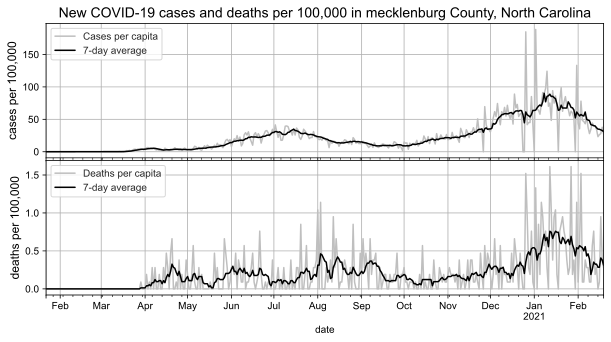

In [58]:
plot_cases(level="county", county="mecklenburg", state="North Carolina");

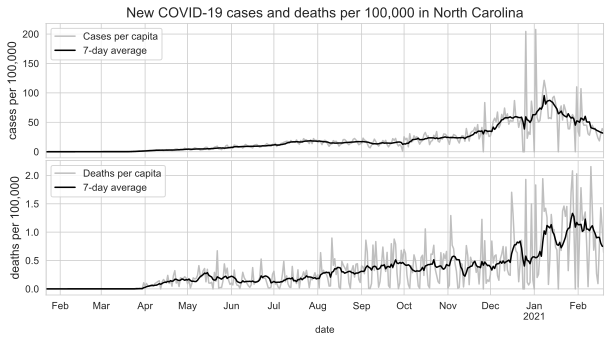

In [59]:
plot_cases(level="state", state="North Carolina");

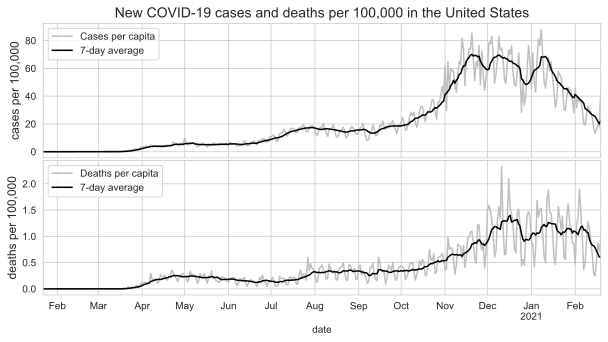

In [60]:
plot_cases(level="national");

## 2.2 <a id='2.2'>Policy data overlay</a>
[back to top](#top)<br>

Get policy data for a specific county at the state and county level, then overlay some selected policy enactments on top of the case / death figures

In [61]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
   
    """Get the policy data at county level, state level, or both.  

    Parameters
    ----------
    state : string 
        selected state
    county : string
        selected county
    state_policies : boolean 
        include policies at the state level (default: True)
    county_policies : boolean 
        include policies at the county level (default: True)
    
    Returns
    ---------- 
    filtered DataFrame
    """
    
    # state AND county policies
    if state_policies and county_policies:

        return df[(df['state'] == state) &
                  ((df["county"] == county) | (df["county"] == "statewide"))]
    
    # state policies only
    elif state_policies and not county_policies: 
        return df[ (df['state'] == state) & (df["county"] == "statewide")]
    
    # county policies only
    else:  
         return df[ (df['state'] == state) & (df["county"] == county)]

In [62]:
def plot_cases_and_policies(
        county, state, 
        colors=sns.color_palette()[:],
        policies=[
            "mandate face masks in public spaces", 
            "mandate face masks in businesses", 
            "shelter in place", 
            "state of emergency"],
                           
        labels=["face mask mandate (public spaces)", 
            "face mask mandate (businesses)", 
            "shelter in place", 
            "state of emergency"],
        save_figure=False, 
        filename="Plot cases and policies figure.png", 
        fig_size=(10, 5), 
        legend_position=(0, 0)
    ):

    
    """Plot the cases overlayed with the policies. 
    
    Parameters
    ---------- 
    county : string 
        county of interest
    state : string
        state of interest
    policies : array-like
        policies to plot (default: face mask mandates in public spaces and businesses, shelter in place, 
        and state of emergency)
    colors : array-like
        line colors for respective policies (in order) (default: k, b, r, g)
    labels : array-like 
        legend labels for the selected policies (default: "face mask mandate (public spaces)", 
        "face mask mandate (businesses)", "shelter in place", and "state of emergency")
    style : string 
        sns plot style (whitegrid by default, dark styles not recommended)
    fade : float
        level of transparency for new_cases_1e6 and new_deaths_1e6 (default: 0.75)
    
    The marks for policies are aligned with the 7 day average, using colors to indicate policy types, endcaps for 
    state (diamond) or county (circle), and linestyle to distinguish the start (solid line) or stop (dotted line) of a 
    policy. 
    
    Returns
    ----------
    ndarray containing the two axis handles used for plotting
    """

    
    # Plot case / death data.
    plt.figure();
    fig, ax, df = plot_cases(level="county", county=county, state=state, fig_size=fig_size);

    # Get the policy data for the selected state and county.
    policy_data = get_policy_data(state, county);

    # Set a solid line to be the start of a policy and a dashed line to be the end.
    styles_start_stop = {
        "start" : '-', 
        "stop" : ':'
    }

    # Set color codes for selected policies.
    styles_policy_type = {policies[i] : colors[i] for i in range(len(policies))}
    
    # Set labels for legend.
    legend_policy_labels = {policies[i] : labels[i] for i in range(len(policies))}
    
    # Define plot parameters.  
    line_split = 0                
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]
    labels = []
    
    # Loop through both axes. 
    for i in range(2):
        
        # Expand y axis to get some extra room on the bottom.
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
        # Loop through policies.
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # Get the y-positional coordinate for the line on the selected day (between 0 and 1). 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
            
            # Calculate where to position the line horizontally.  
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1, but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly.

            num_policies = plot_policies['date'].value_counts()[row.date]
            
            # Split the mark if there are multiple policies enacted on the same day.
            if num_policies > 1: 
                hmin = (cent_coord - (mark_length/2)) + line_split * (mark_length/num_policies)
                hmax = (cent_coord + (mark_length/2)) - \
                    (mark_length/num_policies) + ((line_split*mark_length) / num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord - (mark_length/2))
                hmax = (cent_coord + (mark_length/2))
                line_split=0
                
            # Plot the mark.
            line = ax[i].axvline(x         = row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax,
                                )

            # Add the policy to the legend if it's not already in the list of labels
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
                
            # Set markers for state or county policies. 
            if row.policy_level == "state":
                line.set_marker('d')
                
            else: 
                line.set_marker('o')
                
            ax[i].legend(loc="upper left")
        
    # Make the legend. 
    legend_lines = []
    
    # Use square boxes to denote colors for policy types. 
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    # Draw a diamond to indicate a state policy. 
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="state policy"))
    
    # Draw a circle to indicate a county policy. 
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="county policy"))
    
    # Use a solid line for policy start, dotted line for policy stop. 
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    # Finally, draw the legend. 
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, loc='center',  bbox_to_anchor=legend_position, ncol=4)
    ax[0].add_artist(leg1);
    
    if save_figure: 
        plt.savefig(filename, bbox_inches='tight')
        
    return fig, ax

<Figure size 432x288 with 0 Axes>

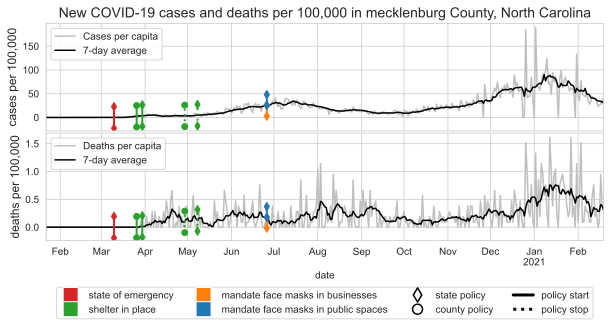

In [64]:
plot_cases_and_policies(county="mecklenburg", 
                        state="North Carolina", 
                        fig_size=(10, 4),
                        save_figure=False,
                        legend_position=(0.5, -1.6),
                        filename="Figures/cases_policies_meck_NC_282021.png");

# 3. <a id='corr'>Connecting case numbers and covid policies</a>
[back to top](#top)<br>

# 3.1 <a id='3.1'>Finding Correlations</a>
[back to top](#top)<br>

Find the correlation between case / death numbers and policies.

To do this, calculate two quantities related to the number of new cases and number of new deaths: <br>
1) (number of new cases / deaths  $x$ days after implementation - number of new cases / deaths on the day of implementation). This is will be called the case(death)\_$x$\_day\_delta<br>

2) (rate of change of new cases / deaths $x$ days after implementation $-$ rate of change of new cases / deaths on the day of implementation). This will be called the case(death)\_$x$\_day\_accel

In [65]:
def calculate_deltas(measure_period=14, 
                     filtered_policies=None, 
                     case_df=df, 
                     policy_df=df2, 
                     state_cases_dict=None): 
    
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    
    Parameters
    ---------- 
    measure_period : int
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    filtered_policies : array-like 
        specify policies to select (defaul: None- calulate deltas for all policies)
    case_df : pandas DataFrame
        DataFrame with case / death information (default: df)
    policy_df : pandas DataFrame
        DataFrame with police information (default: df2)
    
    Returns
    ----------  
    A copy of the covid policies df (df2) with 2 appended columns for the change in case and death numbers. 
    """
    
    # Initialize wait period before measurement.
    wait_period = timedelta(days=measure_period)
    day_1 = timedelta(days=1)
    
    def sub_calc_deltas(ser, date, wait=wait_period): 
        """Wrap repeated calculations in a sub function to avoid repetition."""
        day_1 = timedelta(days=1)
    
        start      = ser[ser.index==date].values[0]
        start_1day = ser[ser.index==date+day_1].values[0]
        
        end        = ser[ser.index==date+wait].values[0]
        end_1day   = ser[ser.index==date+wait+day_1].values[0]
        
        return [start, start_1day, end, end_1day]
    
    # If there we are only examining select policies, then filter those out.
    if filtered_policies is not None: 
        policy_df = policy_df.loc[policy_df['policy_type'].isin(filtered_policies)]
        
    correlated_df = policy_df.copy()
    
    # Initially fill the delta column with nan.
    correlated_df.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"case_{measure_period}_day_accel"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    correlated_df.loc[:, f"death_{measure_period}_day_accel"] = np.nan
    
    # Load all state-aggregated datasets into a dictionary. We expect to need all 50 states so let's take the time to aggregate
    # the state data now so we don't need to do it repeatedly in the loop. 
    
    if state_cases_dict is None: 
        state_cases_dict = dict()
        for state in [elem.name for elem in us.states.STATES]: 
            state_cases_dict[state]=get_cases(level="state", state=state);

    case_df = case_df.set_index('date')
    total_policies = len(policy_df)
    
    for index, data in policy_df.iterrows(): 
          
        # If this is a state-level policy, then we already have the DataFrame to use. 
        if data.policy_level == 'state': 
            state_df = state_cases_dict[data.state]
            ser_cases = state_df['new_cases_7day_1e6' ]
            ser_deaths = state_df['new_deaths_7day_1e6']
        
        # This must be a county level policy- filter the appropriate data. 
        else:
            ser_cases = case_df['new_cases_7day_1e6' ][case_df['fips_code'] == data.fips_code]
            ser_deaths = case_df['new_deaths_7day_1e6'][case_df['fips_code'] == data.fips_code]
        
        # Get the case and death numbers at the appropriate days. 
        c11, c12, c21, c22 = sub_calc_deltas(ser_cases, date=data.date)
        d11, d12, d21, d22 = sub_calc_deltas(ser_deaths, date=data.date)
           
        # Calculate the difference in new cases at the selected dates. 
        correlated_df.at[index, f"case_{measure_period}_day_delta"] = c21 - c11
        correlated_df.at[index, f"death_{measure_period}_day_delta"] = d21 - d11
        
        # Calculate the change in curvature (aka acceleration) of the case / death plots at policy implementation and
        # measure_period days afterwards. 
        
        correlated_df.at[index, f"case_{measure_period}_day_accel"] = ((c12-c11) - (c21-c22)) / measure_period
        correlated_df.at[index, f"death_{measure_period}_day_accel"] = ((d12-d11) - (d21-d22)) / measure_period    
    
    
    return correlated_df, state_cases_dict

In [66]:
print("Changes in cases / deaths 14 days after policy implementations:")
policy_deltas, state_cases_dict = calculate_deltas()
policy_deltas.head()

Changes in cases / deaths 14 days after policy implementations:


,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,25.292215,-0.105470,-0.119947,0.038111
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,1.181946,0.023800,-0.004997,0.000156
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,-0.152593,-0.002194,-0.021983,0.000098
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.213029,0.016448,0.019440,0.001281
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,1.472359,0.019070,0.060381,0.001331


For every policy that was implemented more than 10 times, aggregate the 4 metrics to get the average (avg) and standard deviation (std). 

In [67]:
def calc_delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    Parameters
    ---------- 
    deltas : pandas DataFrame 
        dataframe of policy deltas on which to do the calculations
    measure_period : int 
        time to wait (in days) before measuring a change in new case or death numbers (14 by default)
    min_samples : int 
        minimum number of samples that a policy must have for reporting of average and std (default: 10)
    
    Returns
    ----------   
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """
    # Generate a new list of policy types differentiating between start and stop. 
    policy_types = ([elem + " - start" for elem in deltas['policy_type'].unique()]  
                    + [elem + " - stop"  for elem in deltas['policy_type'].unique()])
    
    # Initialize empty arrays for the associated statistics.
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    case_accel_avg, death_accel_avg, case_accel_std, death_accel_std = [], [], [], []
    
    # Loop through all the policy types.
    for policy in policy_types:
        
        # Determine whether this policy is the beginning or end.  
        if policy.endswith("stop"):
            len_index = -7
            start_stop = "stop"
        else: 
            len_index = -8
            start_stop = "start"
        
        # Get arrays of all the deltas for each type of policy 
        case_data  = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_delta']

        death_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                            (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_delta']

        case_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                 (deltas['start_stop'] == start_stop)][f'case_{measure_period}_day_accel']
         
        death_accel_data = deltas[(deltas['policy_type'] == policy[:len_index]) & 
                                  (deltas['start_stop'] == start_stop)][f'death_{measure_period}_day_accel']

        num_samples.append(len(case_data))
        
        # Calculate the averages and standard deviations for each policy
        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
        
        case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
        death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))
        
        case_accel_std.append(np.nanstd(case_accel_data.to_numpy()))
        death_accel_std.append(np.nanstd(death_accel_data.to_numpy()))
        
        
        
    # Construct the dataframe to tabulate the data.
    delta_stats = pd.DataFrame(np.transpose([case_avg, case_accel_avg, death_avg, death_accel_avg, 
                                             case_std, case_accel_std, death_std, death_accel_std, 
                                             num_samples]), index=policy_types, 
                               columns=['case_avg', 'case_accel_avg', 'death_avg', 'death_accel_avg', 
                                        'case_std', 'case_accel_std', 'death_std', 'death_accel_std', 
                                        'num_samples']
                              )

    # Drop record with less than min_samples samples.
    delta_stats.drop(delta_stats[delta_stats['num_samples'] <= min_samples].index, inplace=True)
    
    return delta_stats

In [68]:
delta_stats = calc_delta_stats(deltas = policy_deltas)
print("Changes in cases and deaths associated with policy implementations:")
delta_stats.head()

<ipython-input-67-715a146e52e3>:52: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-67-715a146e52e3>:53: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-67-715a146e52e3>:58: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-67-715a146e52e3>:59: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


Changes in cases and deaths associated with policy implementations:


,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples
entertainment - start,2.589929,-0.027899,-0.035575,-0.000882,11.818583,0.269728,0.475719,0.023428,149.0
houses of worship - start,3.430665,-0.076693,-0.041497,-0.002565,18.165869,0.415597,0.648928,0.035912,77.0
non-essential businesses - start,4.482265,0.067338,-0.058099,-0.000272,14.647177,0.587288,0.452976,0.021072,181.0
gyms - start,2.445999,0.023406,0.065952,0.000613,3.421345,0.068249,0.237666,0.002709,49.0
allow audio only telehealth - start,3.229401,0.020830,0.148461,0.001169,5.274714,0.051617,0.260330,0.003336,45.0


The "Mean of empty slice" warnings may be safely ignored. These correspond to policies that were never implemented. For example, many countries started 'allow audio only telehealth', but no county or state has stopped such a policy. 

## 3.2 <a id='3.2'>Evaluating Correlations</a>
[back to top](#top)<br>

Plot the 4 metrics as associated variances for each policy 7 days after a given policy implementation to evaluate how well this model performs. 

In [69]:
def eval_delta_stats(delta_stats, 
                     num_days=14, 
                     interval='std', 
                     save_figure=False, 
                     filename="Figures/eval delta stats figure.png"
                    ):
    
    """Evaluate the correlations between policy implementations and new cases / deaths. """
    
    # force interval to std 
    interval = 'std'
    fig, ax = plt.subplots(ncols=4, figsize=[10, 15], sharey=True)

    def eval_color(num, error): 
        if num+error<0: 
            return 'g'
        elif num-error>0: 
            return 'r'
        else: 
            return 'k'

    for i, index in enumerate(delta_stats.index): 
        vals     = delta_stats.loc[index][ :4].values
        vals_std = delta_stats.loc[index][4:-1].values
        n = delta_stats.loc[index][-1]

        for j, (val, val_std) in enumerate(zip(vals, vals_std)):  
    
            # if interval is 'std', set the errorbar to the same width as the std
            if interval == 'std': 
                err = val_std
            # if a confidence interval is specified, set error bar to with width of the desired CI
            else: 
                # Since the population variance is unkown, use the t-score (two-tail)
                # This method is still under development
                t = stats.t.ppf(1-(interval/2), n)
                err = (val + t*(val_std / math.sqrt(n)))
            
            ax[j].errorbar(y=i, 
                        x=val, 
                        xerr=err,
                        marker='.',
                        markersize=15,
                        capsize=5,
                        linewidth=3,
                        linestyle='None',
                        c=eval_color(val, err)
                       )
    titles = ["new cases", "acceleration of new cases", "new deaths", "acceleration of new deaths"]
    for i in range(4):
        lims = ax[i].get_ylim()
        ax[i].vlines(x=0, ymin=lims[0], ymax=lims[1], color='k')
        ax[i].set_ylim(lims)
        ax[i].set_title(titles[i])
        ax[i].tick_params(bottom=True, top=True, labelbottom=True, labeltop=True)
    plt.yticks(range(len(delta_stats.index)), delta_stats.index, fontsize=8)
    if interval == 'std':
        title = f"Correlations in covid policy metrics {num_days} days after implementation (errorbar = std)"
    else: 
        title = f"Correlations in covid policy metrics {num_days} days after implementation (CI = {interval})"
    plt.suptitle(title, y=0.95);
    
    if save_figure: 
        plt.savefig(filename)
    
    return fig

<ipython-input-67-715a146e52e3>:52: RuntimeWarning: Mean of empty slice
  case_avg.append(np.nanmean(case_data.to_numpy()))
<ipython-input-67-715a146e52e3>:53: RuntimeWarning: Mean of empty slice
  death_avg.append(np.nanmean(death_data.to_numpy()))
C:\Users\alexc\anaconda3\envs\covid_project\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
<ipython-input-67-715a146e52e3>:58: RuntimeWarning: Mean of empty slice
  case_accel_avg.append(np.nanmean(case_accel_data.to_numpy()))
<ipython-input-67-715a146e52e3>:59: RuntimeWarning: Mean of empty slice
  death_accel_avg.append(np.nanmean(death_accel_data.to_numpy()))


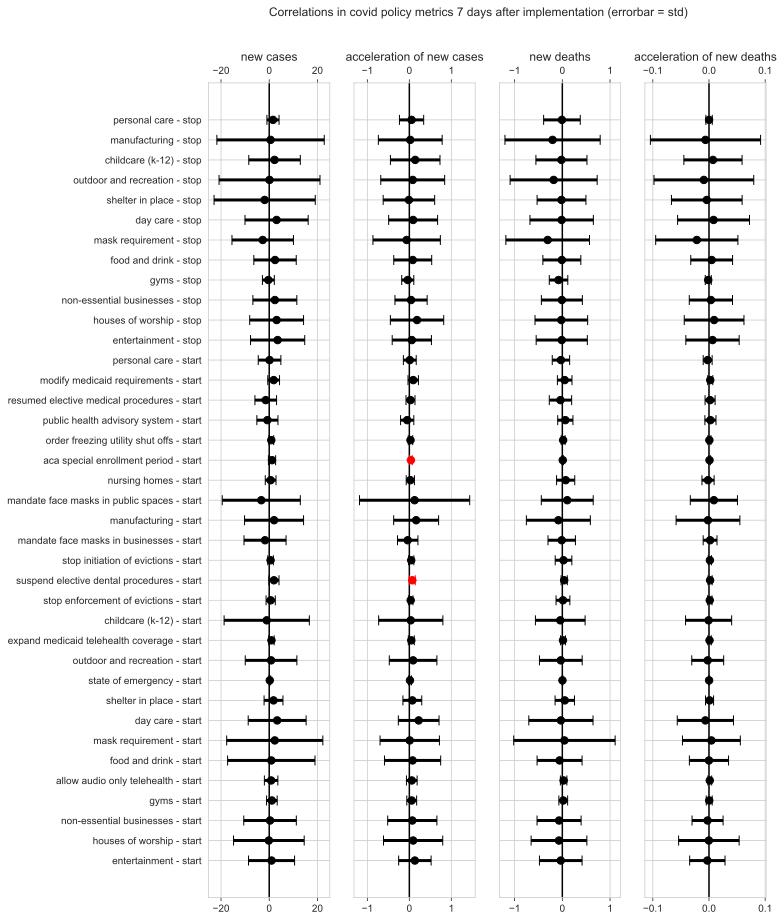

In [70]:
#days = [3, 7, 10, 14, 21]
days = [7]
state_cases_dict = None
for day in days: 
    deltas, state_cases_dict = calculate_deltas(measure_period=day, state_cases_dict=state_cases_dict)
    
    eval_delta_stats(calc_delta_stats(deltas=deltas, measure_period=day), 
                     num_days=day)

Many of these policies don't definitively correlate to an increase or decrease in case / death numbers, except for acceleration in new cases with 'aca special enrollment period - start' and 'suspend elective dental procedures - start'

It is difficult to judge the actual impacts that these policies had based on these visualizations, since these case and death numbers were influenced by a large number of variables, most notably other policy implementations, but also other environmental and societal factors. 

To better quantify how these policies may have impacted the number of cases and deaths, it is necessary to uncouple multiple policy implementations, which calls for a regression algorithm. 

# 4 <a id='4'>Predicting new cases given historical policy implementations</a>
[back to top](#top)<br>

Create a regression model to estimate the number of new cases / deaths given a set of policy implementations. 

## 4.1 <a id='4.1'>Preprocessing</a>
[back to top](#top)<br>

Further process policy data for the model:
- Some policies are very similar, so use a dictionary to group these together and simplify the model. 
- define a new field encoding policy type, level, and whether it was the start or stop of a policy
- Remove policies that were implemented less than 10 times. 

In [71]:
policy_dict = {
    'aca special enrollment period': 'medical', 
    'agriculture': 'agriculture',
    'allow audio only telehealth': 'medical', 
    'alternative care facilities': 'medical', 
    'bars': 'entertainement', 
    'childcare (k-12)': 'childcare', 
    'colleges & universities': 'education',
    'construction': 'construction', 
    'day camps/overnight camps': 'camps', 
    'day care': 'childcare',
    'education': 'education', 
    'election': 'election', 
    'entertainment': 'entertainment', 
    'executive order': 'executive order',
    'expand medicaid telehealth coverage': 'medical', 
    'food and drink': 'entertainment',
    'froze mortgage payments': 'housing', 
    'gatherings': 'gatherings', 
    'grace period / security deposit for rent': 'housing', 
    'graduation': 'graduation',
    'graduation ceremony guidelines': 'graduation', 
    'gyms': 'gyms', 
    'health risk status': 'medical',
    'higher education': 'education', 
    'houses of worship': 'houses of worship', 
    'libraries' : 'education',
    'mandate face masks in businesses': 'mask mandate',
    'mandate face masks in public spaces': 'mask mandate', 
    'manufacturing': 'manufacturing',
    'mask requirement': 'mask mandate', 
    'medical': 'medical', 
    'modify medicaid requirements': 'medical',
    'museums': 'education', 
    'non-essential businesses': 'non-essential businesses', 
    'nursing home visitations': 'nursing homes',
    'nursing homes': 'nursing homes', 
    'order freezing utility shut offs': 'housing',
    'outdoor and recreation': 'outdoor and recreation', 
    'personal care': 'personal care', 
    'public gatherings': 'gatherings',
    'public health advisory system': 'medical', 
    'quarantine': 'shelter in place',
    'residential overnight camps': 'camps',
    'resumed elective medical procedures': 'medical', 
    'shelter in place': 'shelter in place',
    'state of emergency': 'state of emergency', 
    'state of emergency/funds': 'state of emergency',
    'stop enforcement of evictions': 'housing', 
    'stop initiation of evictions': 'housing',
    'suspend elective dental procedures': 'medical', 
    'training jobs': 'training jobs', 
    'travel': 'travel',
    'traveler from out of state': 'travel', 
    'updated guidelines': 'updated guidelines',
    'wholesale trade': 'wholesale trade',
}

In [97]:
def prep_policy_data(df2,
                     policy_dict=policy_dict,
                     min_samples=10):
    """Preprocess the policy data for Machine Learning models.

    Parameters
    ------------
    df2: DataFrame
        policy data
    policy_dict: dictionary
        Dictionary defined in policy_dict.py to rename and aggregate policies.
    min_samples: integer
        Throw out policies that were not implemented min_samples times.

    Returns
    ----------
    proc_policy_data: DataFrame
        The preprocessed policy data
    """

    proc_policy_data = df2.copy()

    # Replace policies with the ones in policy_dict().
    for key in policy_dict.keys():
        proc_policy_data['policy_type'].replace(
            to_replace=key, value=policy_dict[key], inplace=True)

    # Define a new field that includes policy_type, start_stop,
    # and policy_level information
    proc_policy_data.loc[:, 'full_policy'] =\
        proc_policy_data['policy_type'] + " - " +\
        proc_policy_data['start_stop'] + " - " +\
        proc_policy_data['policy_level']

    # Get number of times each policy was implemented.
    num_samples = proc_policy_data['full_policy'].value_counts()

    # drop the policy if it was implemented fewer than min_policy times.
    proc_policy_data = proc_policy_data.drop(proc_policy_data[
        proc_policy_data['full_policy'].isin(
            num_samples[num_samples.values < min_samples].index)
    ].index)

    # return the DataFrame
    return proc_policy_data

df2_preprocessed = prep_policy_data(df2)
print("df2 processed")
df2_preprocessed.head()

df2 processed


,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,full_policy
0,Mississippi,hinds,28049,county,2020-07-13,entertainment,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,entertainment - start - county
1,Arizona,statewide,4,state,2020-05-16,houses of worship,start,Policy_Details: All businesses are open but mu...,sip_submission_form: https://azgovernor.gov/si...,houses of worship - start - state
2,Oregon,statewide,41,state,2020-05-15,non-essential businesses,start,Policy_Details: Currently open: Grocery stores...,sip_submission_form: https://govstatus.egov.co...,non-essential businesses - start - state
5,Connecticut,statewide,9,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,gyms - start - state
6,Michigan,statewide,26,state,2020-03-16,gyms,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,gyms - start - state


**Primary data preprocessing function:** 

This function will join the policy dataset and case / death dataset. The policies will be organized into `bins` - date ranges specifying the time since the given policy implementation.

The dataframe will have the following form: 
    
| info<br>state |  <br>county  | <br>date | <br>num_new_cases | policy name<br>[date range 1]| <br>[date range 2] | <br> [date range 3]|
| ------------- | ------------ | -------  | ----------------- | ------ | ------ | ------ |
| state name    | county name  |   date   | # of new cases    | 0 or 1 | 0 or 1 | 0 or 1 |

In the columns labeled '0 or 1': <br>
1 if the policy was implemented within the selected date range, 0 otherwise.<br> 
Date range 1 will always start at 0 days.<br>
Date range 3 (or the final date range) will always end in 999 (this bin extends all the way to the current day)

Simple example: 

| info<br>state |  <br>county  | <br>date | <br>num_new_cases | policy name<br>0-2| <br>3-5 | <br>6-999|
| ------------- | ------------ | -------  | ----------------- | ------ | ------ | ------ |
| state   | county  | date - 1 | # of new cases | 0 | 0 | 0 |
| state   | county  | policy enacted today | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 1 | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 2 | # of new cases | 1 | 0 | 0 |
| state   | county  | date + 3 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 4 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 5 | # of new cases | 0 | 1 | 0 |
| state   | county  | date + 6 | # of new cases | 0 | 0 | 1 |
| state   | county  | date + 7 | # of new cases | 0 | 0 | 1 |
| state   | county  | date + 8 | # of new cases | 0 | 0 | 1 |
|    |   | ... |  |  |  | |
| state   | county  | today | # of new cases | 0 | 0 | 1 |


The number of bins and bin sizes will be optimized to get the least error from the model. 

In [98]:
def join_policies(case_df,
                  policy_df,
                  output=True,
                  bins_list=[(0, 6), (7, 13), (14, 999)],
                  state_output=False):
    """Data preprocessing for Machine Learning that joins case and policy data.

    This function works by generating a processed DataFrame for each state and
    the concatenating the resulting 50 DataFrames at the very end.

    Parameters
    ------------
    case_df: DataFrame
        case data
    policy_df: DataFrame
        policy data
    output: boolean
        output time elapsed after running
    bins_list: list
        list of tuples with the desired date ranges
        default: [(0, 6), (7, 13), (14, 999)]
    state_output: boolean
        output time elapsed for filtering with each state
        default: False

    Returns
    ------------
    df3: DataFrame
        Processed DataFrame
    """
    time_start = time.time()

    # Define a sub-function to convert passed integers to the desired
    # date range starting from a given date.
    def _get_date_range(date, start_move=0, stop_move=7):

        # Get the date range from date+start_move to date+stop_move
        return pd.date_range(start=date+timedelta(days=start_move),
                             end=date+timedelta(days=stop_move))

    # Ensure all date columns are datetime
    case_df['date'] = pd.to_datetime(case_df['date'], format='%Y-%m-%d')
    policy_df['date'] = pd.to_datetime(policy_df['date'], format='%Y-%m-%d')

    # Make list of all policies.
    all_policies = policy_df['full_policy'].unique()

    # Construct multiIndex for df3.
    tuples_info = [("info", "state"), ("info", "county"), ("info", "full_loc"),
                   ("info", "date"), ("info", "new_cases_1e6")]

    tuples_policies = [(policy,
                        (str(date_range[0]) + "-" + str(date_range[1])))
                       for policy in all_policies for date_range in bins_list]

    tuples_index = tuples_info + tuples_policies
    col_index = pd.MultiIndex.from_tuples(tuples_index)

    # Get list of all states.
    all_states = case_df['state'].unique()

    # Generate a list of empty dataframes- one for each state.
    frames = [pd.DataFrame() for state in all_states]

    # Loop through all states.
    for (i, state) in enumerate(all_states):

        if output:
            state_time_start = time.time()

        # Initiallize dataFrame.
        frames[i] = pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_index),
                                 data={
            ("info", "state"): state,
            ("info", "county"): case_df['county'][case_df['state'] == state],
            ("info", "full_loc"): case_df['full_loc_name'][
                    case_df['state'] == state
                ],
            ("info", "date"): case_df['date'][case_df['state'] == state],
            ("info", "new_cases_1e6"): case_df['new_cases_1e6'][
                case_df['state'] == state]
        })

        # Filter policy data to only those that were enacted in that state.
        filtered_policy = policy_df[policy_df['state'] == state]

        # Loop through every policy that was implemented in the current state.
        for (date, county, policy, level) in zip(filtered_policy['date'],
                                                 filtered_policy['county'],
                                                 filtered_policy[
                                                     'full_policy'],
                                                 filtered_policy[
                                                     'policy_level']):
            # Loop through each bin
            for date_bin in bins_list:

                # calculate the date range
                date_range = _get_date_range(date, date_bin[0], date_bin[1])

                # Generate label (this is the 2nd level label in the
                # multiIndexed column)
                label = (str(date_bin[0]) + "-" + str(date_bin[1]))

                # For every record in frames that falls within the date range
                # of the specific policy, set the appropriate column to 1.
                frames[i].loc[(
                    (frames[i]['info', 'date'].isin(date_range)) &
                    ((frames[i]['info', 'county'] == county) |
                     (level == 'state')) &
                    (frames[i]['info', 'state'] == state)),
                    (policy, label)] = 1

        if state_output:
            state_time_end = time.time()
            print(f"{state}: {state_time_end - state_time_start} seconds")

    # Concat the DataFrames
    df3 = pd.concat([frames[i] for i in range(len(frames))])

    # Fill NaNs
    df3.fillna(0, inplace=True)
    time_end = time.time()

    if output:
        print("data shaped\nbins: {}\ntime elapsed: {}".format(
            bins_list, (time_end - time_start)))

    return df3

In [99]:
print("testing data preprocessing")
df3 = join_policies(case_df = df, policy_df = df2_updated.copy(), output=True);

testing data preprocessing
data shaped
bins: [(0, 6), (7, 13), (14, 999)]
time elapsed: 99.5201313495636


Filter df3 to a random policy implementation to check verify all calculations executed correctly.

In [100]:
# Select a random policy
rand_index = random.randint(0, len(df2_updated)-1)
rand_policy = df2_updated.iloc[rand_index]

print("Randomly selected policy:\n ")
print(df2_updated.iloc[rand_index])

# If this is a statewide policy, select a random county from that state
if rand_policy.county == 'statewide': 
    county = random.choice(df3['info', 'county'][df3['info', 'state'] == rand_policy.state].unique())
else: 
    county = rand_policy.county

print("\nAssociated DataFrame slice:\n ")

# Show a slice of the processed DataFrame with the chosen policy and location. 
df3.loc[(df3['info', 'date'] >= rand_policy.date - timedelta(days=1)) &\
        (df3['info', 'county'] == county) &\
        (df3['info', 'state'] == rand_policy.state), 
        [('info', 'date'), 
         ('info', 'county'),
         ('info', 'state'),
         (rand_policy.full_policy, '0-6'), 
         (rand_policy.full_policy, '7-13'), 
         (rand_policy.full_policy, '14-999')]].head(20)

Randomly selected policy:
 
state                                                 Mississippi
county                                                      wayne
fips_code                                                   28153
policy_level                                               county
date                                          2020-07-20 00:00:00
policy_type                                     houses of worship
start_stop                                                   stop
comments        Policy_Details: Executive Order by Governor Ta...
source          sip_submission_form: https://www.sos.ms.gov/co...
full_policy                     houses of worship - stop - county
Name: 345, dtype: object

Associated DataFrame slice:
 


info                     houses of worship - stop - county       \
             date county        state                               0-6 7-13   
615194 2020-07-19  wayne  Mississippi                                 0    0   
615195 2020-07-20  wayne  Mississippi                                 1    0   
615196 2020-07-21  wayne  Mississippi                                 1    0   
615197 2020-07-22  wayne  Mississippi                                 1    0   
615198 2020-07-23  wayne  Mississippi                                 1    0   
615199 2020-07-24  wayne  Mississippi                                 1    0   
615200 2020-07-25  wayne  Mississippi                                 1    0   
615201 2020-07-26  wayne  Mississippi                                 1    0   
615202 2020-07-27  wayne  Mississippi                                 0    1   
615203 2020-07-28  wayne  Mississippi                                 0    1   
615204 2020-07-29  wayne  Mississippi                                 0    1   
615205 2020-07-30  wayne  Mississippi                                 0    1   
615206 2020-07-31  wayne  Mississippi                                 0    1   
615207 2020-08-01  wayne  Mississippi                                 0    1   
615208 2020-08-02  wayne  Mississippi                                 0    1   
615209 2020-08-03  wayne  Mississippi                                 0    0   
615210 2020-08-04  wayne  Mississippi                                 0    0   
615211 2020-08-05  wayne  Mississippi                                 0    0   
615212 2020-08-06  wayne  Mississippi                                 0    0   
615213 2020-08-07  wayne  Mississippi                                 0    0   

               
       14-999  
615194      0  
615195      0  
615196      0  
615197      0  
615198      0  
615199      0  
615200      0  
615201      0  
615202      0  
615203      0  
615204      0  
615205      0  
615206      0  
615207      0  
615208      0  
615209      1  
615210      1  
615211      1  
615212      1  
615213      1

In some cases, it appears that the same policy was implemented twice. This is likely due to the fact that similar policies were grouped together

The table below illustrates what I'm talking about. In this example, A policy was implemented on day 2 and a similar policy type was implemented on day 6. 

 | date | bin1 | bin2 |
 | ---- | ---- | ---- |
 | day 1| 0 | 0 |
 | day 2| 1 | 0 |
 | day 3| 1 | 0 |
 | day 4| 0 | 1 |
 | day 5| 0 | 1 |
 | day 6| 1 | 1 |
 | day 7| 1 | 1 |
 | day 8| 0 | 1 |
 
This is currently of no serious concern, but may need to be referenced in future iterations of this project in case any issues arise. 

## 4.2 <a id='4.2'>Test a Model</a>
[back to top](#top)<br>

Fit an ordinary least-squares model and check for sensible results. This is to ensure that the above functions are working properly.

In [102]:
X = df3.loc[:, df3.columns[5:]].values
y = df3.loc[:, ('info', 'new_cases_1e6')].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

Implement a function to evaluate model performance by plotting the coefficients of each policy at each time period of interest. The plotting functionality only works with algorithms that have an .coef_ attribute. 

In [103]:
def eval_model(regressor,
               df3, 
               print_coefs=False,
               plot_results=False,
               X_test=X_test,
               y_test=y_test):
    coefficients = regressor.coef_
    if print_coefs: 
        print(f"R score: {regressor.score(X_test, y_test)}")
        print(f"regression coefficients:")
        print(coefficients)
    
    results = pd.DataFrame(index=df3.columns[5:], data={"coefficient": coefficients})
    results = results.unstack()
    
    if plot_results: 
        
        # plot the relative magnitudes of the weights for each policy
        side_size = int(np.ceil(math.sqrt(len(results.index))))

        fig, ax = plt.subplots(nrows=side_size, ncols=side_size, figsize=[side_size*5, side_size*5])

        i = j = 0 # j = column, i = row
        x = [elem [1] for elem in results.columns.tolist()]

        for index in results.index: 
            if j == side_size: 
                j = 0
                i += 1
            g = sns.scatterplot(x=x, 
                            y=results.loc[index].values, 
                            ax=ax[i][j],
                            s=300, 
                            hue=results.loc[index].values)
            g.legend_.remove()
            ax[i][j].set_title(index)
            j+=1

        fig.suptitle("# new cases associated with covid policies", y=0.89);
    return results, coefficients

results, coefficients = eval_model(regressor, df3, print_coefs=True, plot_results=False)

R score: 0.09135420287794527
regression coefficients:
[ 1.84652142e+01  1.59806089e+01 -1.28610106e+00 -6.49818754e+00
 -7.09875443e+00 -3.86336651e-01 -6.06578304e+00 -5.18359665e+00
 -3.24789379e+00 -1.96342562e+00 -1.93056086e+00 -3.47102831e+00
 -2.35339132e+00 -2.29411088e+00  6.46501250e+00 -6.13022209e+00
 -5.17002033e+00 -2.90754290e+00 -1.10758148e+00 -2.17494878e+00
  6.88417695e+00 -3.39661639e+00 -4.73661601e+00 -5.38600865e+00
  1.74146776e+00  6.79217918e+00  1.29148151e+01 -1.22408873e+01
 -1.00651859e+01 -2.79476993e+00 -2.76815626e+00 -4.04639932e+00
  2.12333121e+00  1.94474979e+00  1.83322435e+00 -2.92113714e+00
 -9.81424579e+00 -9.43593549e+00  8.48436318e-01  4.91505961e+00
  7.30966535e+00  1.23905534e+01 -1.60183645e+00 -1.33219973e+00
 -5.92130475e+00  3.04865062e+00  1.85664914e+00  7.20075321e+00
 -3.65342330e-01  7.07620314e-01  1.29070193e+00  5.53889433e+00
  2.62424309e+00  1.40093003e+00 -3.61500034e+00 -4.48615826e+00
 -2.10598734e+00 -1.61137942e+01 -1.

This model has a very low R-squared, so there is much improvement to be had. However, the coefficients appear to be taking on reasonable values, suggesting that the data has been processed appropriately.

## 4.3 <a id='4.3'>Train / test split</a>
[back to top](#top)<br>

Split into training set and test set (add more details later)

In [104]:
def county_split(df, test_size):
    """Documentation pending
    """
    all_counties = df['full_loc_name'].unique()

    # shuffle the list
    np.random.shuffle(all_counties)

    # split the data
    counties_test = all_counties[: int(len(all_counties)*test_size)]
    counties_train = all_counties[int(len(all_counties)*test_size):]

    df_test = df[df['full_loc_name'].isin(counties_test)]
    df_train = df[df['full_loc_name'].isin(counties_train)]

    return df_train, df_test

In [107]:
# This was run on 2/20/2021 - Do NOT run this line again to keep potential models from seeing data from the test set.
# case_data_train, case_data_test = county_split(df, test_size=0.2)

Now save the training and test set into a csv file. This is to that the split only happens once in the life of this project.

In [110]:
# case_data_train.to_csv("{}train_data.csv".format(DATASETS_DIR))
# case_data_test.to_csv("{}test_data.csv".format(DATASETS_DIR))

## 4.4 <a id='4.4'>Systematic model training</a>
[back to top](#top)<br>
Systematically work through a series of bin selections and regression models to identify hopeful candidates. Save the R squared values in a csv file (this process is expected to take a long time).

Declare 3 functions to loop through different bins, models, and apply K-fold cross validation 

In [149]:
def train_model(df_train_proc,
                results_df,
                model_id,
                model,
                metrics_dict,
                bin_id,
                K=10,
                verbose="full",
                save_out_log=True,
                log_file="log.txt",):
    """Function to train models using K-fold cross validation
    Parameters
    -----------
    df_train_proc: DataFrame
        Processed dataframe with features and targets
    results_df: DataFrame
        MultiIndex dataframe summarizing results
    model_id: string
        Unique identifier for model (e.g. 'Lasso' for lasso regression)
    model: call to an sklearn object
        call to the models constructor method
    metrics_dict: dictionary
        dictionary of metrics to measure performance: key=id, value=method call
    bin_id: integer
        unique ID of bin distrubution (use for outputs and logging)
    K: integer
        number of cross-validation folds
    verbose: {"full", "limited", "off"}
        Degree with which to print results
    save_out_log: boolean
        If true, save the results of verbose output to a text file
    log_file: string (filepath)
        File path to log output file
    Returns
    ----------
    """
    # Initialize results dictionary
    results_dict = {metric: [] for metric in metrics_dict.keys()}

    # Get unique list of counties to shuffle
    counties = df_train_proc[('info', 'full_loc')].unique()

    # shuffle the counties
    np.random.shuffle(counties)
    batch_size = int(len(counties) / K)

    # Logging and outputs.
    msg1 = f"num cross-validation folds: {K}"
    msg2 = f"num counties in validation set: {batch_size}"

    if verbose == "full":
        print(msg1)
        print(msg2)
    if save_out_log:
        with open(log_file, "a") as log:
            log.write(msg1)
            log.write(msg2)

    # Train models K times, each time leaving out a different portion of the
    # data fro cross-validation.
    for k in range(K):

        # Select the train and validation portion.
        df_train = df_train_proc[~df_train_proc[
            ('info', 'full_loc')].isin(
                counties[k*batch_size:(k+1)*batch_size])]

        df_validate = df_train_proc[df_train_proc[
            ('info', 'full_loc')].isin(
                counties[k*batch_size:(k+1)*batch_size])]

        # Split into features and targets
        X_train = df_train.loc[:, df_train.columns[5:]].values
        y_train = df_train.loc[:, ('info', 'new_cases_1e6')].values

        X_validate = df_validate.loc[:, df_validate.columns[5:]].values
        y_validate = df_validate.loc[:, ('info', 'new_cases_1e6')].values

        # Train the model
        model.fit(X_train, y_train)

        # Calculate scores.
        for metric in metrics_dict.keys():
            score = metrics_dict[metric](y_validate, model.predict(X_validate))

            # Append scores to the output objects
            results_dict[metric].append(score)
            results_df.loc[(metric, k), (bin_id, model_id)] = score

        # Outputs
        results = [(str(metric) + ": " + str(results_dict[metric][k]))
                   for metric in metrics_dict.keys()]

        msg = f"fold: {k}, scores: {results}"
        if verbose:
            print(msg)
        if save_out_log:
            with open(log_file, "a") as log:
                log.write(msg)

    return results_dict, results_df, model.get_params()

In [150]:
def loop_models(df_train_proc,
                results_df,
                models_dict,
                metrics_dict,
                bin_id,
                K=10,
                verbose="full",
                save_out_log=True,
                log_file="log.txt"):
    """Loop through and train each model.
    Parameters
    -----------
    df_train_proc: DataFrame
        Processed dataframe with features and targets
    results_df: DataFrame
        MultiIndex dataframe summarizing results
    models_dict: dictionary
        dictionary of models: key=id, value=constructor
    metrics_dict: dictionary
        dictionary of metrics to measure performance: key=id, value=method call
    bin_id: integer
        unique ID of bin distrubution (use for outputs and logging)
    K: integer
        Number of folds for cross-validation
    verbose: {"full", "limited", "off"}
        Degree with which to print results
    save_out_log: boolean
        If true, save the results of verbose output to a text file
    log_file: string (filepath)
        File path to log output file
    Returns
    -----------
    results: dictionary
    results_df: DataFrame
    """

    # declare an empty dictionary to hold results
    results = {}

    # loop through all the models passed
    for model_id in models_dict.keys():

        # Output status.
        msg = f"running models: {model_id}"
        if verbose != "off":
            print(msg)
        if save_out_log:
            with open(log_file, "a") as log:
                log.write(msg)

        # declare empty dictionary for results from this one run
        model_results = {}
        scores, results_df, params = train_model(df_train_proc=df_train_proc,
                                                 results_df=results_df,
                                                 model_id=model_id,
                                                 model=models_dict[model_id],
                                                 metrics_dict=metrics_dict,
                                                 bin_id=bin_id,
                                                 K=K,
                                                 verbose=verbose,
                                                 save_out_log=save_out_log,
                                                 log_file=log_file,)

        # Save the results in a dictionary
        model_results['params'] = params
        model_results['scores'] = scores
        results[model_id] = model_results

    return results, results_df

In [151]:
def run_batch(df_train,
              df2_preprocessed,
              bins_dict,
              models_dict,
              metrics_dict,
              K=10,
              verbose="full",
              save_out_log=True,
              save_json_output=True,
              log_file="log.txt",
              json_file="results.json",
              overwrite=True):
    """For each set of bins, loop through every model and do cross validation.
    Parameters
    -----------
    df_train: DataFrame
        Processed training dataframe with case info
    df2_preprocessed: DataFrame
        Processed policy dataframe
    bins_dict: dictionary
        dictionary of bins: key=id, value=list of bins
    models_dict: dictionary
        dictionary of models: key=id, value=constructor
    metrics_dict: dictionary
        dictionary of metrics to measure performance: key=id, value=method call
    K: integer
        Number of folds for cross-validation
    verbose: {"full", "limited", "off"}
        Degree with which to print results
    save_out_log: boolean
        If true, save the results of verbose output to a text file
    save_json_output: boolean
        If true, save the final results to a json file
    log_file: string (filepath)
        File path to log output file
    json_file: string (filepath)
        File path to json output file
    overwrite: boolean
        If true, delete output logs if names overlap
        (avoids accidental overwritting)
    Returns
    ----------
    results_df: DataFrame
        multi-indexed DataFrame with all metrics
    """

    # Initialize dictionary for results (for json outputs).
    results = {}

    # Initialize multi-index DataFrame for results.
    all_bins = list(bins_dict.keys())
    models = list(models_dict.keys())
    metrics = list(metrics_dict.keys())

    cols = pd.MultiIndex.from_product(
        [all_bins, models], names=["bin id", "model"])
    index = pd.MultiIndex.from_product(
        [metrics, range(K)], names=["metric", "sample"])

    results_df = pd.DataFrame(columns=cols, index=index)

    # Delete old log files if overwritting and the file already exists.
    if overwrite & os.path.exists(log_file):
        os.remove(log_file)
    if overwrite & os.path.exists(json_file):
        os.remove(json_file)

    # loop through all bin types.
    for i, bin_id in enumerate(bins_dict):
        bins_list = bins_dict[bin_id]

        # Output to console and/or log file.
        msg = "bins: {}".format(bins_list)
        if verbose != "off":
            print(msg)
        if save_out_log:
            with open(log_file, "a") as log:
                log.write(msg)

        # Feature engineering with the selected bins.
        df_train_proc = join_policies(case_df=df_train,
                                      policy_df=df2_preprocessed,
                                      output=True,
                                      bins_list=bins_list,
                                      state_output=False)

        # Train all models for the given bin
        model_results, results_df = loop_models(df_train_proc=df_train_proc,
                                                results_df=results_df,
                                                models_dict=models_dict,
                                                metrics_dict=metrics_dict,
                                                bin_id=bin_id,
                                                K=K,
                                                verbose=verbose,
                                                save_out_log=save_out_log,
                                                log_file=log_file)

        # Add the dictionary of results to master dictionary
        model_results['bins'] = bins_list
        results[bin_id] = model_results

    # Save the json output
    if save_json_output:
        if overwrite & os.path.exists(json_file):
            os.remove(json_file)

        with open(json_file, 'w') as file:
            json.dump(results, file)

    # Return the results dataframe
    return results_df

Run these functions for a small set of models

In [171]:
# Declare dictionaries with parameters
bins_dict = {
    0: [(0, 999)],
    1: [(0, 10), (11, 999)],
    2: [(0, 20), (21, 999)],
    }

models_dict = {
    'OLS': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    }

metrics_dict = {
    'R^2': r2_score,
    'MSE': mean_squared_error
    }

# Load the training set
df_train = pd.read_csv("{}train_data.csv".format(DATASETS_DIR), index_col=0)

# Set output file name
output_file_name = "{}test_run_2_20".format(RESULTS_DIR)

# Run the models
results_df = run_batch(df_train=df_train,
                      df2_preprocessed=df2_preprocessed, 
                      bins_dict=bins_dict, 
                      models_dict=models_dict,
                      metrics_dict=metrics_dict,
                      K=10,
                      verbose="full",
                      save_out_log=True,
                      save_json_output=True,
                      log_file="{}.txt".format(output_file_name), 
                      json_file="{}.json".format(output_file_name),
                      overwrite=True)

bins: [(0, 999)]
data shaped
bins: [(0, 999)]
time elapsed: 40.746206283569336
running models: OLS
num cross-validation folds: 10
num counties in validation set: 251
fold: 0, scores: ['R^2: 0.10907652497619524', 'MSE: 2056.4121638920005']
fold: 1, scores: ['R^2: 0.06949567772536314', 'MSE: 3074.3402928069504']
fold: 2, scores: ['R^2: 0.06361779953869273', 'MSE: 3722.203212901613']
fold: 3, scores: ['R^2: 0.07343240663545259', 'MSE: 3270.136793448814']
fold: 4, scores: ['R^2: 0.08012333171726216', 'MSE: 2837.2968962077744']
fold: 5, scores: ['R^2: 0.10672763852237999', 'MSE: 2162.8913659344603']
fold: 6, scores: ['R^2: 0.07527695180364025', 'MSE: 2844.7435897552573']
fold: 7, scores: ['R^2: 0.045804275316741694', 'MSE: 4733.574278443229']
fold: 8, scores: ['R^2: 0.07671540515684927', 'MSE: 2658.6618584002476']
fold: 9, scores: ['R^2: 0.08194410383658868', 'MSE: 2808.191280740732']
running models: Ridge
num cross-validation folds: 10
num counties in validation set: 251
fold: 0, scores: [

In [172]:
# Save the results dataframe
results_df.to_csv("{}_DataFrame.csv".format(output_file_name))

Now visualize these results: 

In [173]:
results_df

bin id                   0                                      1  \
model                  OLS        Ridge        Lasso          OLS   
metric sample                                                       
R^2    0          0.109077     0.091964     0.082382     0.074413   
       1          0.069496     0.089785     0.082754     0.059798   
       2          0.063618     0.086282     0.073453     0.099928   
       3          0.073432      0.06215     0.068438     0.110603   
       4          0.080123     0.094175     0.055752     0.089516   
       5          0.106728     0.095948     0.046858     0.076667   
       6          0.075277     0.058016     0.071455     0.072365   
       7          0.045804      0.06627     0.074655     0.098646   
       8          0.076715     0.057339     0.052321     0.073196   
       9          0.081944     0.075205     0.067639     0.088132   
MSE    0       2056.412164  2127.586004  2429.689162   3384.24733   
       1       3074.340293  2733.695663  2334.176263  4380.631521   
       2       3722.203213  2420.443113  2784.584017  2424.554253   
       3       3270.136793  3798.930353  2608.223246  1995.701448   
       4       2837.296896  2107.172739  3550.457998  2746.221035   
       5       2162.891366  2309.289544  4334.281924  2822.844771   
       6        2844.74359  3765.837624  2852.208847  3399.460155   
       7       4733.574278  3921.666347  2775.356498  2434.788237   
       8       2658.661858  3952.772253  3951.494908  3591.881283   
       9       2808.191281  3066.017856  2882.639761  2791.490531   

bin id                                             2                            
model                Ridge        Lasso          OLS        Ridge        Lasso  
metric sample                                                                   
R^2    0          0.090954     0.057978     0.101874     0.069789     0.063193  
       1          0.093053     0.074077     0.092645     0.102977     0.066696  
       2           0.08122     0.065104     0.086797     0.088847     0.073931  
       3           0.07582     0.052432       0.0849     0.114268     0.075399  
       4          0.090965     0.070333     0.062732     0.081344     0.072378  
       5          0.085019     0.074548     0.076381     0.068383     0.092174  
       6           0.05636     0.079375     0.106738     0.097257     0.056854  
       7          0.122646     0.081291     0.081708      0.07379     0.096442  
       8          0.081963     0.075878     0.105043     0.133665     0.093483  
       9          0.071172     0.091382      0.10275     0.084486     0.091845  
MSE    0       2572.673959  3632.979477  2467.258761  3847.313879  3721.917982  
       1       2377.506618  2974.033685  2710.824319  2459.512968  3475.418762  
       2       3106.726913   3397.39325  3270.061095  3012.200506  3241.588616  
       3       3306.709893  4074.486002   2838.84375  2364.615677  2941.108145  
       4        2948.87576  3175.693234   4153.65627  2897.302685   3205.53703  
       5        2817.17401  3040.133086  3638.705107   3831.76069   2431.12803  
       6       4607.987945  2514.351237   2431.03268  2592.031037  4040.899902  
       7       1876.557843  2513.419366  3267.408051  3539.848305  2174.609098  
       8       2846.601906  2699.313287  2480.610621  1930.640882  2389.551101  
       9       3486.540033  2314.807174  2501.867145  3292.187102  2541.172408

6
----------
row:  0
col:  0
end of row, resetting j
----------
row:  1
col:  0
end of row, resetting j
----------
row:  2
col:  0


IndexError: index 2 is out of bounds for axis 0 with size 2

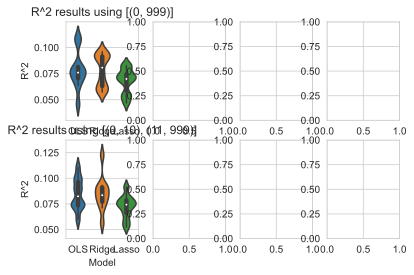

In [184]:
def plot_model_results(results_df=results_df, **kwargs):
    metrics = results_df.index.get_level_values(level=0).unique()
    bins = results_df.columns.get_level_values(level=0).unique()
    
    num_plots = len(metrics) * len(bins)
    ncols = 4
    nrows = math.ceil(num_plots / 4)
    print(num_plots)
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    i, j = 0, 0
    for metric in metrics: 
        for bin_id in bins: 
            # Generate facet plot distribution with all bins and models
            print("----------")
            
            print("row: ", j)
            print("col: ", i)
            plot_df = results_df.loc[(metric,), (bin_id,)]
            sns.violinplot(data=plot_df, ax=ax[j][i], **kwargs)
            ax[j][i].set_title("{} results using {}".format(metric, bins_dict[bin_id]))
            ax[j][i].set_xlabel("Model")
            ax[j][i].set_ylabel(metric)
            if i % 4 == 0: 
                print("end of row, resetting j")
                i = 0
                j += 1
            else: 
                i += 1
            
            
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plot_model_results(results_df, bw=0.3)

## 4.5 <a id='4.5'>Model Selection</a>

Now that everything is up and running, systematically work through multiple selections of bins and models to get an idea of the correct set of hyperparameters.

**Bins**: 
| id | bins |
| --- | --- |
| 0 | 0-10, 11-999 |
| 1 |0-50, 51-999 |
| 2 | 0-100, 101-999 |
| 3 | 0-3, 4-10, 11-999 |
| 4 | 0-3, 4-20, 21-999 |
| 5 | 0-3, 4-50, 51-999 |
| 6 | 0-10, 11-20, 21-999 |
| 7 | 0-10, 11-40, 41-999 |
| 8 | 0-10, 11-60, 61-999 |
| 9 | 0-20, 21-40, 41-999 |
| 10 | 0-20, 21-60, 61-999 |
| 11 | 0-20, 21-100, 101-999 |
| 12 | 0-10, 11-20, 21-30, 31-40, 41-50, 51-999 |
| 13 | 0-10, 11-30, 31-60, 61-100, 101-150, 151-210, 211-999 |
| 14 | 0-20, 21-40, 41-60, 61-100, 101-140, 141-200, 201-999 |

**Models**: 
- Orinary Least Squares (linear regression)
- Ridge Regression
- Lasso Regression
- Elastic Net Regression
- Stochastic Gradient Descent
- Decision Tree Regression
- Random Forest Regression (with 10 estimators)

**Metrics**: 
- R^2
- Mean Squared Error (MSE)
- Mean Absolute Error (MAE)

In [82]:
bins_dict = {
    
    # 2 bins
    0: [(0, 10), (11, 999)],
    1: [(0, 50), (51, 999)], 
    2: [(0, 100), (101, 999)], 
    
    # 3 bins
    3: [(0, 3), (4, 10), (11, 999)], 
    4: [(0, 3), (4, 20), (21, 999)], 
    5: [(0, 3), (4, 50), (51, 999)], 
    6: [(0, 10), (11, 20), (21, 999)], 
    7: [(0, 10), (11, 40), (41, 999)], 
    8: [(0, 10), (11, 60), (61, 999)],
    9: [(0, 20), (21, 40), (41, 999)],
    10: [(0, 20), (21, 60), (61, 999)],
    11: [(0, 20), (21, 100), (101, 999)],
    
    # some other bin distributions
    12: [(0, 10), (11, 20), (21, 30), (31, 40), (41, 50), (51, 999)],
    13: [(0, 10), (11, 30), (31, 60), (61, 100), (101, 150), (151, 210), (211, 999)],
    14: [(0, 20), (21, 40), (41, 60), (61, 100), (101, 140), (141, 200), (201, 999)],
}

bins dictionary initialized
bin 0: [(0, 10), (11, 999)]
bin 14: [(0, 20), (21, 40), (41, 60), (61, 100), (101, 140), (141, 200), (201, 999)]


**Summary**
- Decision Tree and Random Forest (n=10) appear to be the best performing models thus far. 
- There is no significant improvement when using a Random Forest, so we will stick with Decision Trees. 
- The best performing bin distribution is bin_id = 13: [(0, 10), (11, 30), (31, 60), (61, 100), (101, 150), (151, 210), (211, 999)]
- While testing this function, repeated runs have demostrated that the R squared is changing enough such that each run may result in a different optimal bin distribution. In the next iteration of this project, I will train numerous decision trees on the same set of bins to characterize how the R squared value is changing. This is may be due to different datapoints being selected in the train/test split section. 

# 5 <a id='5'>Conclusions and Future Work</a>
[back to top](#top)<br>

To summarize, 2 datsets were cleaned: one on the covid-19 case and death numbers and another on policy data. The case and policy data were plotted at the county and state level and correlated with policy implementations. The numerous policy implementations were aggregated together to developed a model that correlated the change in new case and death numbers 7 days after a policy implementation. Finally, the categorical policy data was encoded and joined with the case and death numbers to develop a regression model meant to predict the number of new covid cases given historical policy implementations. The most promising cadidate thus far is a decision tree, with $R^2 \approx 0.25$.  

**TODO**
- Fix bug in section 2.2 (doesn't work when overlaying 3 or more policies)
- Write up descriptions of each algorithm used for my own edification
- Apply decision trees repeatedly to understand how and why the model performance is changing - likely due to the train-test-split. Will likely need to include cross-validation
- Try multiple bin distributions similar to the one(s) that gave the best results